# Person Detection Dataset and Pipeline

In previous work, we have shown how the Faster-RCNN model used for person detection does not generalize well to the Styled-Coco dataset.
In a two step (top-down) human-pose estimation pipeline, the pose estimation model only receives the persons estimaded by the detector. Therefore,
having an accurate person detector is of paramount importance for the success of the end-to-end approach.

In this notebook, we show how to use the different methods and pipelines used to train and evaluate the Faster-RCNN method.

In [1]:
import os
import sys

import numpy as np
import cv2
import torch
from torch.nn import DataParallel
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

sys.path.append("..")

from data.data_loaders import get_detection_dataset
import data.data_processing as data_processing
import lib.utils as utils
import lib.bounding_box as bbox_lib
import lib.visualizations as visualizations
from lib.transforms import unnormalize, prepare_image_detector
from CONFIG import CONFIG
import CONSTANTS

DetectorTrainLib = __import__("02_train_faster_rcnn")

In [2]:
exp_name = os.path.join("notebook_tests", "faster_rcnn_test")
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
data_path = CONFIG["paths"]["data_path"]

In [3]:
%reload_ext autoreload
%autoreload 2

# Loading Dataset

The custom dataset class **DetectionCoco** processes the images from the (possibly styled) COCO dataset to perform object/person detection.
Using the method *get_detection_dataset*, it is possibly to directly obtain data loaders for both training and validation splits.

In [4]:
exp_data = utils.load_experiment_parameters(test_exp)
exp_data["dataset"]["dataset_name"] = "coco"
# exp_data["dataset"]["dataset_name"] = "styled_coco"

In [5]:
train_loader, valid_loader, train_set,\
    valid_set = get_detection_dataset(exp_data=exp_data, train=True, validation=True, get_dataset=True,
                                      shuffle_train=False, shuffle_valid=False, class_ids=[1])

loading annotations into memory...
Done (t=8.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [6]:
img, meta = train_set[7]

In [7]:
meta

{'image_name': '000000005802.jpg',
 'original_image_name': '000000005802.jpg',
 'targets': {'image_id': 5802,
  'boxes': tensor([[ 15.0400,  73.0300, 290.0500, 470.4800],
          [391.6800, 179.4000, 477.1200, 451.6500]]),
  'labels': tensor([1., 1.]),
  'area': tensor([52256.7266, 14095.0977]),
  'iscrowd': tensor([0., 0.])},
 'image_id': 5802}

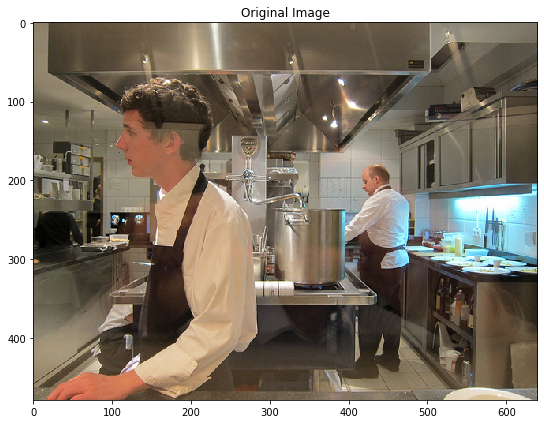

In [8]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 6)
ax.imshow(img.transpose(1,2,0))
ax.set_title("Original Image")
plt.tight_layout()
plt.show()

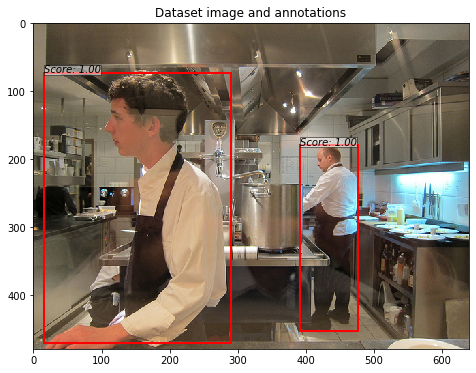

In [9]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

title = "Dataset image and annotations"
visualizations.visualize_bbox(img.transpose(1,2,0), boxes=meta['targets']["boxes"], labels=meta['targets']["labels"],
                              scores=[1,1], ax=ax, title=title)

plt.show()

# Train/Eval Pipeline

In the following cells, we test the training and evaluation pipeline of the Faster-RCNN model.

In [10]:
detectorTrainer = DetectorTrainLib.DetectorTrain(test_exp) 
detectorTrainer.exp_data["dataset"]["dataset_name"] = "coco"

In [11]:
detectorTrainer.load_detection_dataset()

loading annotations into memory...
Done (t=8.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
creating index...
index created!


## Loading Pretrained

In [17]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 1 + 1)
model = DataParallel(model)

In [18]:
pretrained_path = os.path.join(test_exp, "models", "detector", "checkpoint_epoch_10.pth")
checkpoint = torch.load(pretrained_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
# detectorTrainer.load_detector_model()
detectorTrainer.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
detectorTrainer.model = model.to(detectorTrainer.device)

## Computing loss for one image

In [78]:
detectorTrainer.model.train()
pass

In [79]:
imgs, metas = next(iter(detectorTrainer.train_loader))
imgs = imgs.to(detectorTrainer.device).float()

d = {}
d["boxes"] = metas["targets"]["boxes"][0,:].to(detectorTrainer.device).float()
d["labels"] = metas["targets"]["labels"][0,:].to(detectorTrainer.device).long()
targets = [d]

loss_dict = detectorTrainer.model(imgs/255, targets)
loss = sum(loss for loss in loss_dict.values())
print(f"Loss for the image: {round(loss.item(),3)}")

Loss for the image: 0.421


## Visualizing results for the Image

In [80]:
detectorTrainer.model.eval()
outputs = detectorTrainer.model(imgs/255)

In [81]:
boxes, labels, scores = bbox_lib.bbox_filtering(outputs, filter_=1, thr=0.7)

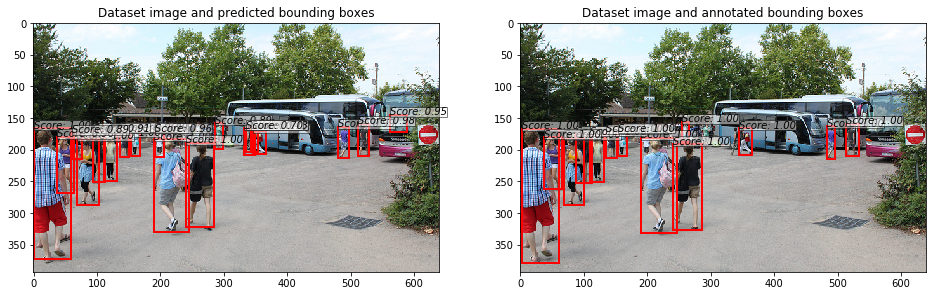

In [82]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,6)

title = "Dataset image and predicted bounding boxes"
visualizations.visualize_bbox(imgs[0,:].cpu().numpy().transpose(1,2,0) / 255, boxes=boxes[0], labels=labels[0],
                              scores=scores[0], ax=ax[0], title=title)

title = "Dataset image and annotated bounding boxes"
visualizations.visualize_bbox(imgs[0,:].cpu().numpy().transpose(1,2,0) / 255, boxes=d["boxes"], labels=d["labels"],
                              scores=[1]*len(d["labels"]), ax=ax[1], title=title)


plt.show()

## Evaluating Model

In [28]:
detectorTrainer.model.eval()
pass

In [29]:
detectorTrainer.validation_epoch()

100%|██████████| 2693/2693 [03:23<00:00, 13.25it/s]


Accumulating evaluation results...
DONE (t=1.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.725
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 